#ESRGAN Citation:

@InProceedings{wang2018esrgan,

    author = {Wang, Xintao and Yu, Ke and Wu, Shixiang and Gu, Jinjin and Liu, Yihao and Dong, Chao and Qiao, Yu and Loy, Chen Change},
    
    title = {ESRGAN: Enhanced super-resolution generative adversarial networks},
    
    booktitle = {The European Conference on Computer Vision Workshops (ECCVW)},
    month = {September},
    year = {2018}
}

https://github.com/xinntao/ESRGAN

https://www.kaggle.com/models/kaggle/esrgan-tf2/code

In [1]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

ModuleNotFoundError: No module named 'tensorflow_hub'

ESRGAN: Enhanced Super-Resolution Generative Adversarial Networks

Authors: Xintao Wang, Ke Yu, Shixiang Wu, Jinjin Gu, Yihao Liu, Chao Dong, Chen Change Loy, Yu Qiao, Xiaoou Tang

"The Super-Resolution Generative Adversarial Network (SRGAN) is a seminal work that is capable of generating realistic textures during single image super-resolution. However, the hallucinated details are often accompanied with unpleasant artifacts. To further enhance the visual quality, the authors thoroughly study three key components of SRGAN - network architecture, adversarial loss and perceptual loss, and improve each of them to derive an Enhanced SRGAN (ESRGAN)."

"In particular, the authors introduced the Residual-in-Residual Dense Block (RRDB) without batch normalization as the basic network building unit. Moreover, they borrowed the idea from relativistic GAN to let the discriminator predict relative realness instead of the absolute value."

"Finally, they improved the perceptual loss by using the features before activation, which could provide stronger supervision for brightness consistency and texture recovery. Benefiting from these improvements, the proposed ESRGAN achieves consistently better visual quality with more realistic and natural textures than SRGAN and won the first place in the PIRM2018-SR Challenge"

https://arxiv.org/abs/1809.00219

I have no clue how to arrive to that URL below. The image is on Xinntao Github.

In [2]:
# Declaring Constants
IMAGE_PATH = "/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0000.jpg"
SAVED_MODEL_PATH = "/kaggle/input/esrgan-tf2/tensorflow2/esrgan-tf2/1"

#Helper Functions

In [3]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [4]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

#Performing Super Resolution of images loaded from path

In [5]:
hr_image = preprocess_image(IMAGE_PATH)

Saved as Original Image.jpg


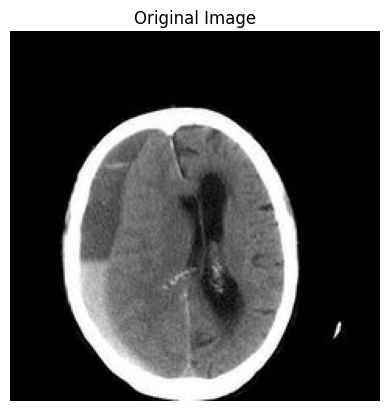

In [6]:
# Plotting Original Resolution image
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")

In [7]:
model = hub.load(SAVED_MODEL_PATH)

In [8]:
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 8.539911


Saved as Super Resolution.jpg


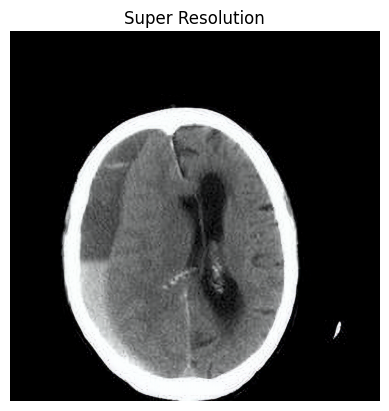

In [9]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution")

#Another URL that I've No clue how to get it.

In [10]:
IMAGE_PATH = "/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0000.jpg"

#Evaluating Performance of the Model

In [11]:
# Defining helper functions
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [12]:
hr_image = preprocess_image(IMAGE_PATH)

In [13]:
lr_image = downscale_image(tf.squeeze(hr_image))

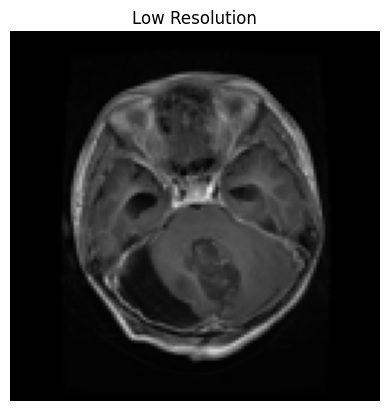

In [14]:
# Plotting Low Resolution Image
plot_image(tf.squeeze(lr_image), title="Low Resolution")

In [15]:
model = hub.load(SAVED_MODEL_PATH)

In [16]:
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 2.930717


PSNR Achieved: 33.841949


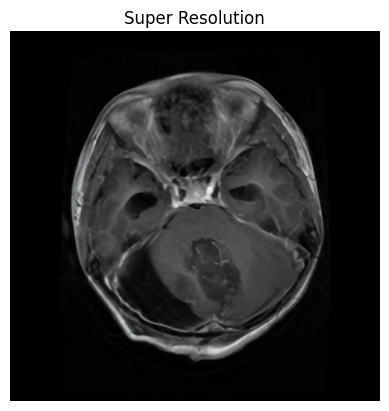

In [17]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
# Calculating PSNR wrt Original Image
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)

#Comparing Outputs size by side.

PSNR: 33.841949


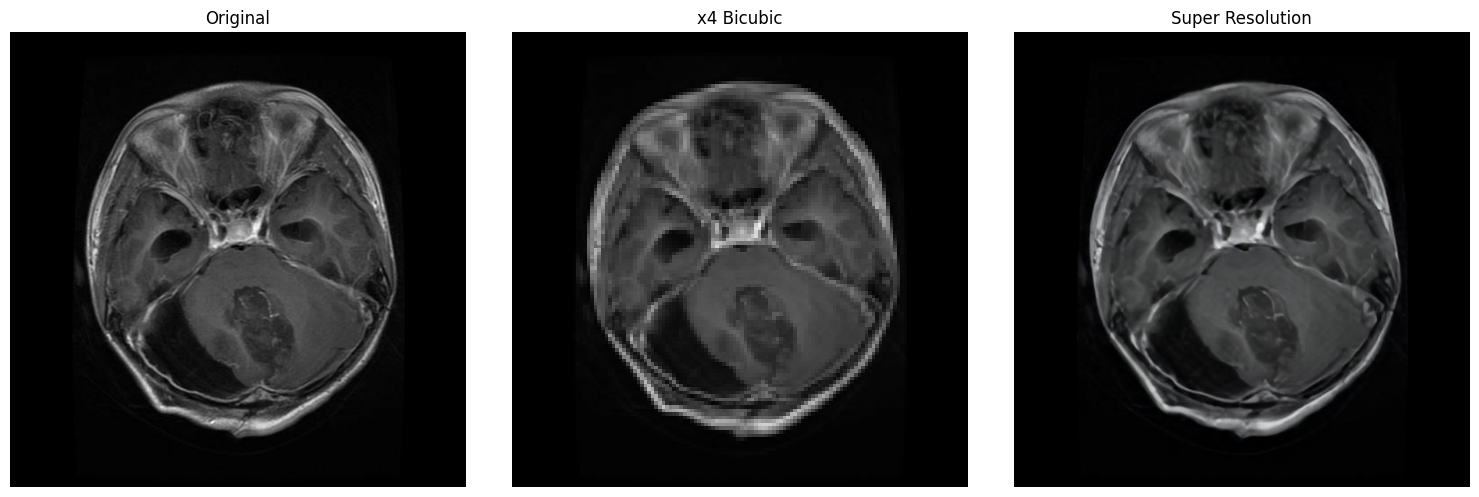

In [18]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 Bicubic")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")
print("PSNR: %f" % psnr)

#Acknowledgements:

Kaggle Kerneler https://www.kaggle.com/code/kerneler/image-super-resolution-using-esrgan